# Currency

## FINM 36700: Portfolio and Risk Management

### UChicago Financial Mathematics

#### Autumn 2024

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

In [38]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
#from treasury_cmds import *
from portfolio import *

$$\newcommand{\frn}{*}$$

$$\newcommand{\RF}{R^{f,\$}}$$
$$\newcommand{\RFa}{R^{f,\frn}}$$

$$\newcommand{\rflog}{\texttt{r}^{f,\$}}$$
$$\newcommand{\rfalog}{\texttt{r}^{f,\frn}}$$

$$\newcommand{\Fcrncy}{F^{\$}}$$
$$\newcommand{\fcrncylog}{\texttt{f}^{\$}}$$

$$\newcommand{\FX}{S}$$
$$\newcommand{\fxlog}{\texttt{s}}$$

# Currency

Currency is traded on the **spot** market at the **exchange rate**.

## Derivatives

Currency derivatives include, (in descending order of size/importance)
* forwards
* swaps
* futures
* options

A few notes on the sizes here...
* Forward currency market is larger than interest-rate forwards!
* Swaps market for currency is about 10% the size of interest-rate swaps.
* Currency options are relatively small, yet still about 1/3 the size of equity options!

### Notable Features
* FX markets are smaller than rates markets, but still huge.
* FX trades mostly in spot, forwards, and swaps
* Relatively small amount in options or futures

### References
OTC Derivatives Size

https://stats.bis.org/statx/srs/table/d5.1

Futures Markets Size

https://stats.bis.org/statx/srs/table/d1

Trading Turnover

https://stats.bis.org/statx/srs/table/d11.1

# Data

`fx_carry_data.xlsx`.

## Risk-free rates
It reports the risk-free rates for various currencies.
- The data is defined such that the March value of the risk-free rate corresponds to the rate beginning in March and ending in April.
- In terms of the class notation, $r^{f,i}_{t,t+1}$ is reported at time $t$. (It is risk-free, so it is a rate from $t$ to $t+1$ but it is know at $t$.

## Exchange rates
Spot exchange rates.

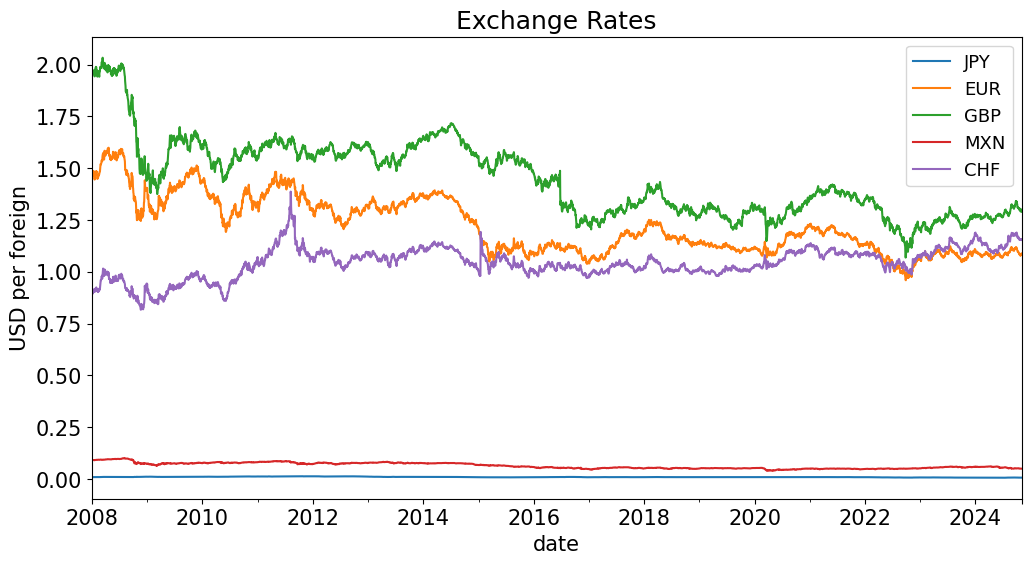

In [39]:
DATAPATH_FX = '../data/fx_rf_data.xlsx'
SHEET = 'exchange rates'

fxraw = pd.read_excel(DATAPATH_FX, sheet_name=SHEET).set_index('date')
fxraw.plot(title='Exchange Rates',ylabel='USD per foreign');

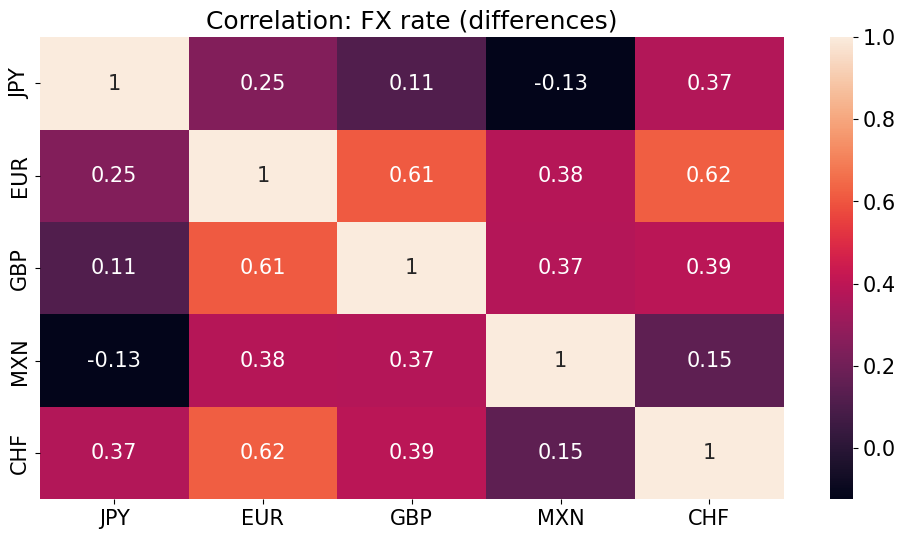

In [40]:
sns.heatmap(fxraw.diff().corr(),annot=True)
plt.title('Correlation: FX rate (differences)');

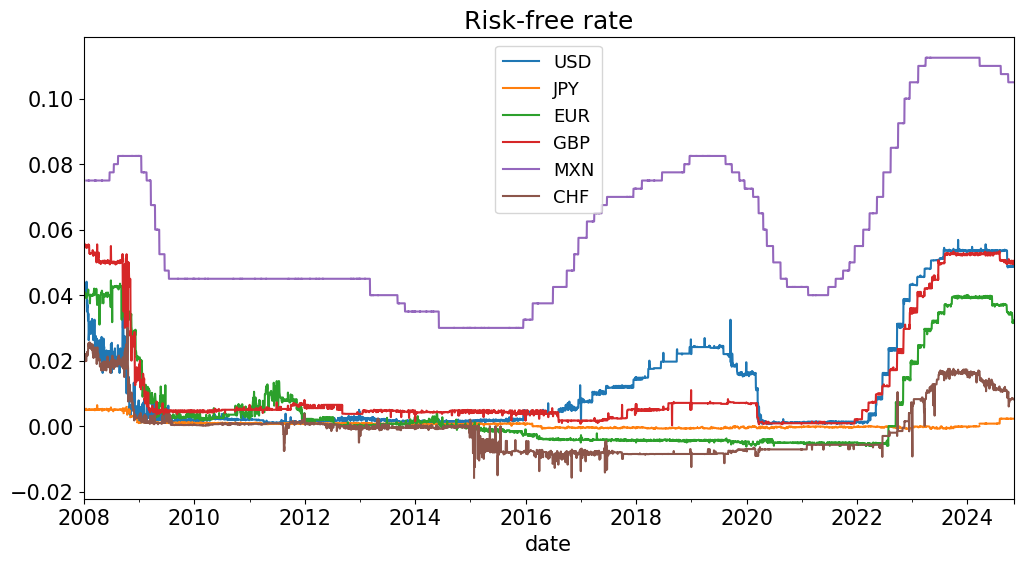

In [41]:
SHEET = 'risk-free rates'

rfraw = pd.read_excel(DATAPATH_FX,sheet_name=SHEET).set_index('date')
rfraw.plot(title='Risk-free rate');

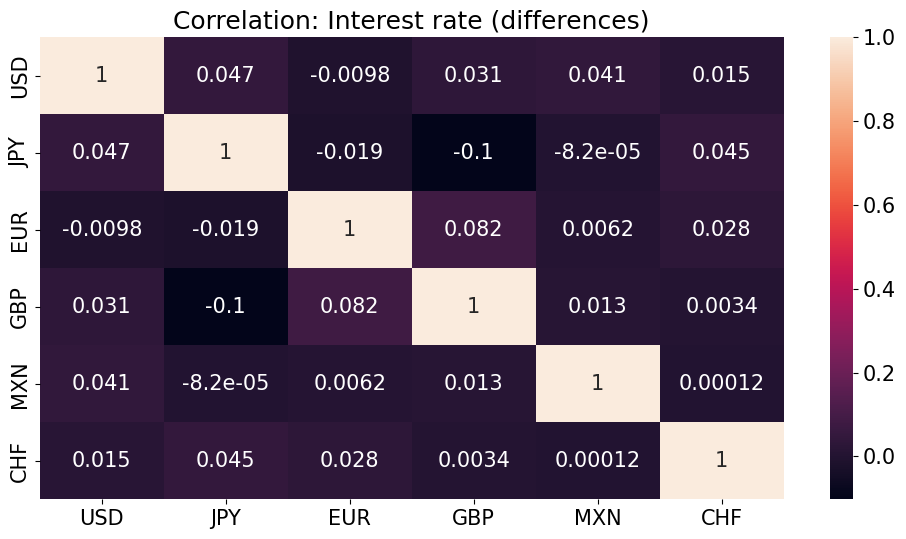

In [42]:
sns.heatmap(rfraw.diff().corr(),annot=True)
plt.title('Correlation: Interest rate (differences)');

<Axes: >

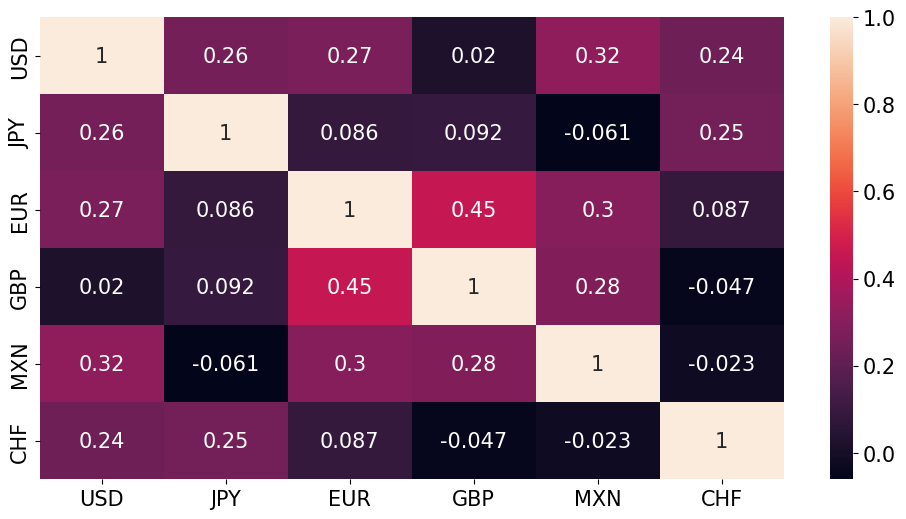

In [43]:
temp = rfraw.resample('ME').last()
sns.heatmap(temp.diff().corr(),annot=True)

# Returns

### Notation

* $S_t$ denotes the foreign exchange rate, expressed as USD per foreign currency
* $\RF_{t,t+1}$ denotes the risk-free factor on US dollars (USD).
* $\RFa_{t,t+1}$ denotes the risk-free factor on a particular foreign currency.

### Two components to returns

Misconception that the return on currency is the percentage change in the exchange rate:
$$\frac{S_{t+1}}{S_t}$$

The price of the currency is $S_t$ dollars.
* In terms of USD, the payoff at time t + 1 of the Euro riskless asset is 
$$\RFa_{t,t+1} S_{t+1}$$

That is, 
* we capitalize any FX gains, 
* but we also earn the riskless return accumulated by the foreign currency.

Thus, the USD return on holding Euros is given by,
$$\RFa_{t,t+1}\frac{ S_{t+1}}{S_t}$$

In [44]:
shared_indexes = rfraw.index.intersection(fxraw.index)

# Split the merged DataFrame back into the original two DataFrames with shared indexes
rf = rfraw.loc[shared_indexes,:]
fx = fxraw.loc[shared_indexes,:]

In [45]:
USDRF = 'USD'

DAYS = fx.resample('YE').size().median()
rf /= DAYS

rfusd = rf[[USDRF]]
rf = rf.drop(columns=[USDRF])

fxgrowth = (fx / fx.shift())
rets = fxgrowth.mul(1+rf.values,axis=1) - 1
rx = rets.sub(rfusd.values,axis=1)

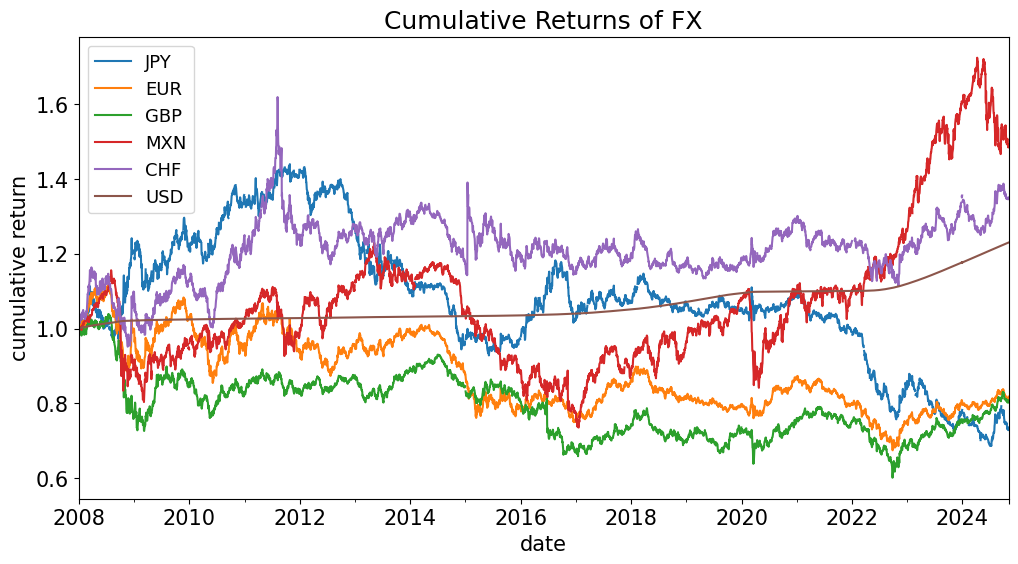

In [46]:
fig, ax = plt.subplots()
(1+rets).cumprod().plot(ax=ax)
(1+rfusd).cumprod().plot(ax=ax)
plt.title('Cumulative Returns of FX')
plt.ylabel('cumulative return')
plt.show()

### Extra Statistics on Returns

Main takeaway:
* small mean return--only exciting if you use leverage
* substantial volatility
* large drawdowns (tail-events)

In [47]:
performanceMetrics(rx,annualization=DAYS).style.format('{:.2%}')

,Mean,Vol,Sharpe,Min,Max
JPY,-2.67%,10.17%,-26.23%,-5.33%,3.91%
EUR,-2.00%,9.17%,-21.85%,-2.40%,3.51%
GBP,-2.07%,9.73%,-21.25%,-8.05%,3.15%
MXN,2.13%,13.23%,16.10%,-7.63%,6.90%
CHF,1.17%,11.11%,10.55%,-8.69%,21.52%


In [48]:
tailMetrics(rets)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
JPY,0.171607,5.334199,-0.009501,-0.014191,-0.523363,2011-10-28,2024-07-03,None,None
EUR,0.139723,2.401010,-0.008893,-0.012795,-0.395366,2008-07-11,2022-09-27,None,None
GBP,-0.722604,10.024629,-0.009266,-0.013887,-0.421011,2008-07-15,2022-09-26,None,None
MXN,-0.575720,7.400524,-0.012601,-0.019335,-0.401902,2013-05-08,2017-01-18,2022-11-07 00:00:00,None
CHF,6.757984,227.421810,-0.009111,-0.013203,-0.312111,2011-08-09,2022-11-03,None,None


## Decomposing the Returns

Using logs, we can split out the two components of excess log returns

### Logarithms
The data is mostly analyzed in logs, as this simplifies equations later.
* For monthly rates, logs vs levels won't make a big difference.

### Excess returns

The (USD) return in excess of the (USD) risk-free rate is then

$$\tilde{r}^i_{t+1} \equiv \fxlog^i_{t+1} - \fxlog^i_t + r^{f,i}_{t,t+1} - r^{f,\$}_{t,t+1}$$

### Two spreads
For convenience, rewrite this as

$$\tilde{r}^i_{t+1} \equiv \left(\fxlog^i_{t+1} - \fxlog^i_t\right) + (\rfalog_{t,t+1} - \rflog_{t,t+1})$$


#### Data Consideration
1. Build the spread in risk-free rates: 

$$\rflog_{t,t+1} - \texttt{r}^{f,*}_{t,t+1}$$

Lag this variable, so that the March-to-April value is stamped as April.

2. Build the FX growth rates: 

$$ \fxlog^i_{t+1} - \fxlog^i_t$$

These are already stamped as April for the March-to-April FX growth.

Then the excess log return is simply the difference of the two objects.

In [49]:
logFX = np.log(fx)
logRFraw = np.log(rfraw+1)
logRFusd = logRFraw[[USDRF]]
logRF = logRFraw.drop(columns=[USDRF])

logRFusd = np.log(rfusd+1)
logRF = np.log(rf+1)

logRFspread = -logRF.subtract(logRFusd.values,axis=0)
logRFspread = logRFspread.shift(1)

logFXgrowth = logFX.diff(axis=0)

logRX = logFXgrowth - logRFspread.values

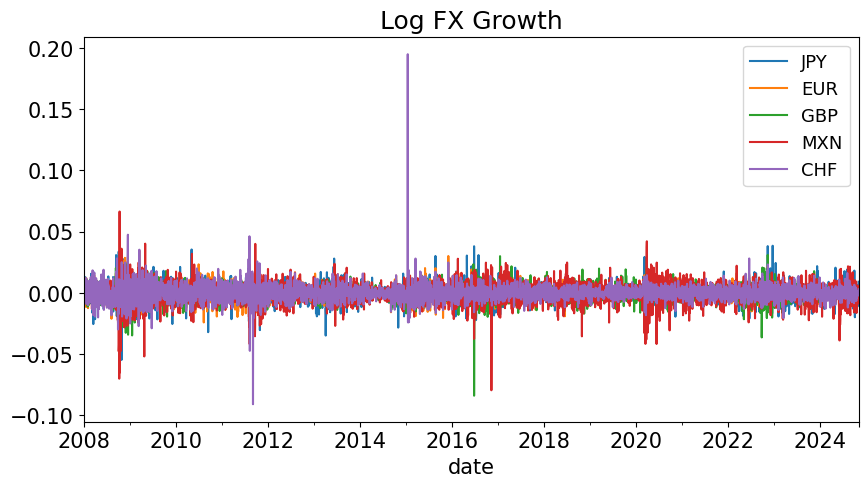

In [50]:
logFXgrowth.plot(title='Log FX Growth', figsize=(10,5));

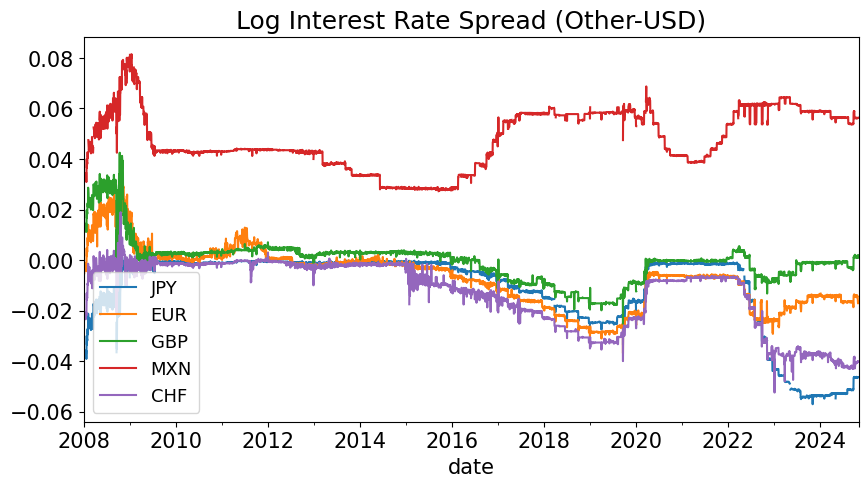

In [51]:
(-logRFspread*DAYS).plot(title='Log Interest Rate Spread (Other-USD)', figsize=(10,5));

In [52]:
rx_components = logFXgrowth.mean().to_frame()
rx_components.columns=['FX effect']
rx_components['RF effect'] = -logRFspread.mean().values
rx_components['Total'] = rx_components.sum(axis=1)
rx_components *= DAYS
rx_components.style.format('{:.2%}')

,FX effect,RF effect,Total
JPY,-1.83%,-1.18%,-3.02%
EUR,-1.74%,-0.68%,-2.42%
GBP,-2.57%,-0.01%,-2.57%
MXN,-3.61%,4.80%,1.19%
CHF,1.61%,-1.31%,0.31%


***

# Covered Interest Parity

### Currency Forwards

Let $\Fcrncy_t$ denote the forward rate on the one-period FX contract, $S_{t+1}$.
* The forward FX rate, $\Fcrncy$, is a rate contracted at time t regarding the exchange of currency at some future time, t + k .
* Here, we just consider one-period forward rates. That is, where $T_2$ is $T_1+1$.
* The superscript \$ is simply to distinguish this as an FX forward versus an interest rate forward.

### Pricing Equation
**Covered Interest Parity** is a market relationship between exchange rates and risk-free rates.
$$\frac{\Fcrncy_t}{S_t}\RFa_{t,t+1} = \RF_{t,t+1}$$

In logs,
$$\fcrncylog_t - \fxlog_t + \rfalog_{t,t+1} = \rflog_{t,t+1}$$

or rather, the forward-premium equals the interest rate differential:

$$\frac{\Fcrncy_t}{S_t} = \frac{\RF_{t,t+1}}{\RFa_{t,t+1}}$$

$$\fcrncylog_t - \fxlog_t = \rflog_{t,t+1} - \rfalog_{t,t+1}$$

### CIP and No Arbitrage

Consider two ways of moving USD from t to t + 1. 
1. Invest in the USD risk-free rate.
2. Invest in the Euro risk-free rate.
    - Buy Euros, invest in the Euro risk-free rate
    - simultaneously use a forward contract to lock in the time t + 1 price of selling the Euros back for USD.

The second strategy replicates the first, so CIP follows just from no arbitrage, (Law of One Price.)

## Takeaway

Due to Covered Interest Parity,
* Pricing the forward on FX is easy: just look at the current exchange rate and the interest rate differential.
* The forward premium (spread between forward and spot) is often used to measure the difference in interest rates across countries.

# Predictability

**Uncovered Interest Parity (UIP)** is a popular model for forecasting exchange rates.

$$\mathbb{E}_t\left[\frac{\FX_{t+1}}{\FX_t}\right] = \frac{\RF_{t,t+1}}{\RFa_{t,t+1}}$$

## Uncovered FX Trading

Consider two ways of moving USD from t to t + 1.

1. At time t, one could simply invest in the USD risk-free rate.
2. Invest in the Euro risk-free rate:
    - At time t, one could buy Euros to invest in the Euro risk-free rate.
    - Then at time t + 1 convert the payoff back to dollars.

The first investment is riskless while the second involves uncertainty about the future exchange rate.

UIP claims the expected depreciation of the USD will exactly offset any interest rate premium over the Euro.

## Market Predictions

### Exchange Rates

* UIP relates expected FX growth to interest rate differential.
* UIP (combined with CIP) says that **forwards** are the **market expectation** of future spot rates:

$\begin{align}
\mathbb{E}_t\left[\frac{\FX_{t+1}}{\FX_t}\right] = & \frac{\Fcrncy_{t}}{\FX_{t}} \hspace{.5cm} \Longrightarrow \hspace{.5cm}  \mathbb{E}_t\left[\FX_{t+1}\right] =  \Fcrncy_{t}
\end{align}$


### Excess Returns
The UIP model implies that the **expected excess return** of currency is zero.
* UIP allows that there may be a return in any given trade or sample.
* But it states that on average, across a wide sample, it will be near zero.

$$\mathbb{E}_t\left[\text{excess return}\right] \equiv \mathbb{E}_t\left[\frac{\FX_{t+1}}{\FX_t}\right]\RFa_{t,t+1}-\RF_{t,t+1} = 0$$

### Evidence from Passive Returns
Above we looked at return data on various currencies.
* The mean excess returns were not **significantly** (in a statistical sense,) different than zero.
* This seemingly supports the UIP.

However, further analysis would show that
* currency growth is not predictable with interest-rate differentials
* the future spot is not well predicted by today's forward.

And thus,
* mean excess returns to currency are positive if a trader reacts to predictable signals, such as forward premium or interest-rate spread.

Traders can take advantage of the fact that interest-rate differentials (nor current forward rates) are good predictors of FX movements.

This is is known as the **carry trade**.

#### An additional note analyzes the trade.

***

# Cryptocurrency

## Crypto Data

For a more thorough description of Crypto, see the references below.

Here, we simply look at the data of the 4 largest cryptocurrencies.

In [53]:
LOADFILE = '../data/crypto_data.xlsx'
crypto = pd.read_excel(LOADFILE,sheet_name='prices').set_index('Date')

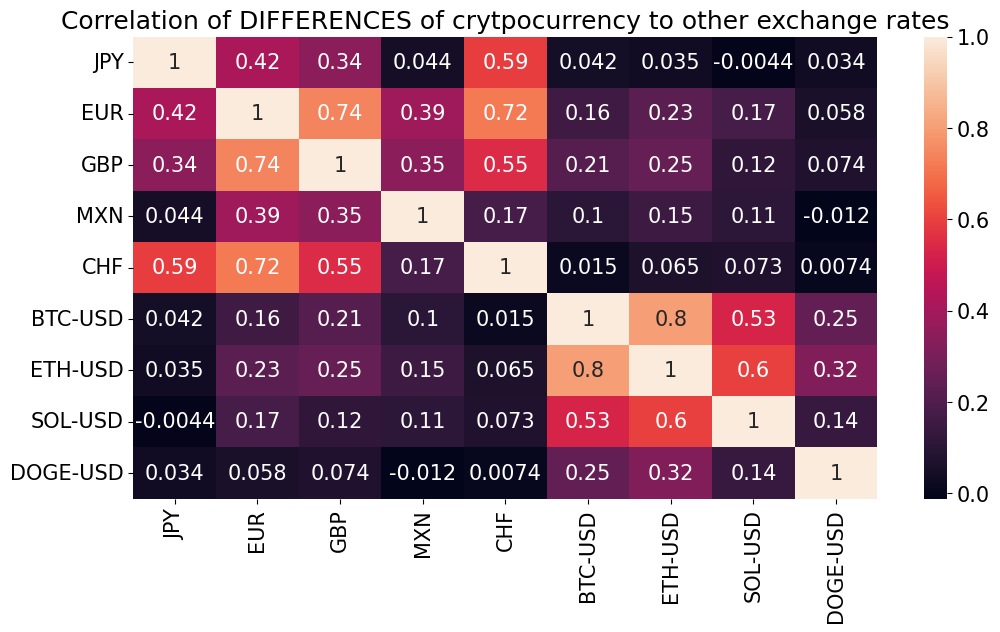

In [54]:
currency = pd.concat([fx,crypto],axis=1).dropna()
rets_fx_wkly = currency.resample('W').last().pct_change()

sns.heatmap(rets_fx_wkly.corr(),annot=True);
plt.title('Correlation of DIFFERENCES of crytpocurrency to other exchange rates');

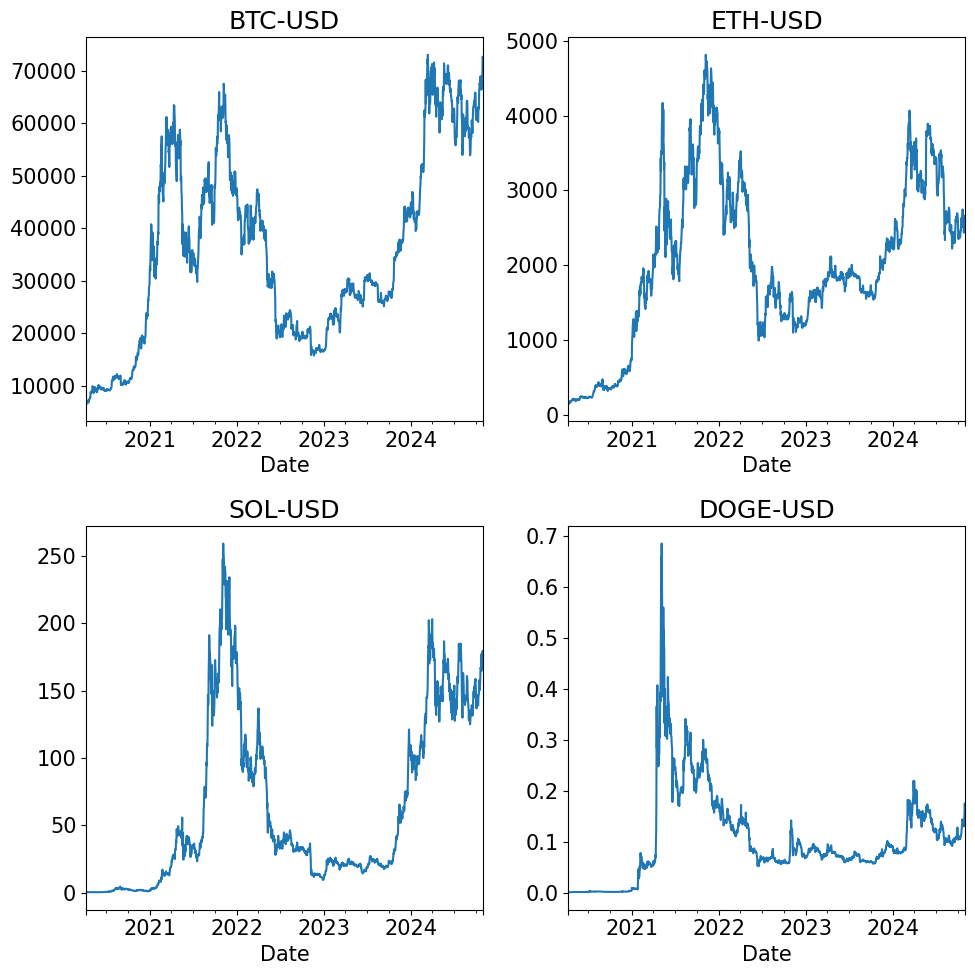

In [55]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
for i, col in enumerate(crypto.columns):
    crypto[col].plot(ax=ax[int(i/2),i%2], title=col)

plt.tight_layout()
plt.show()

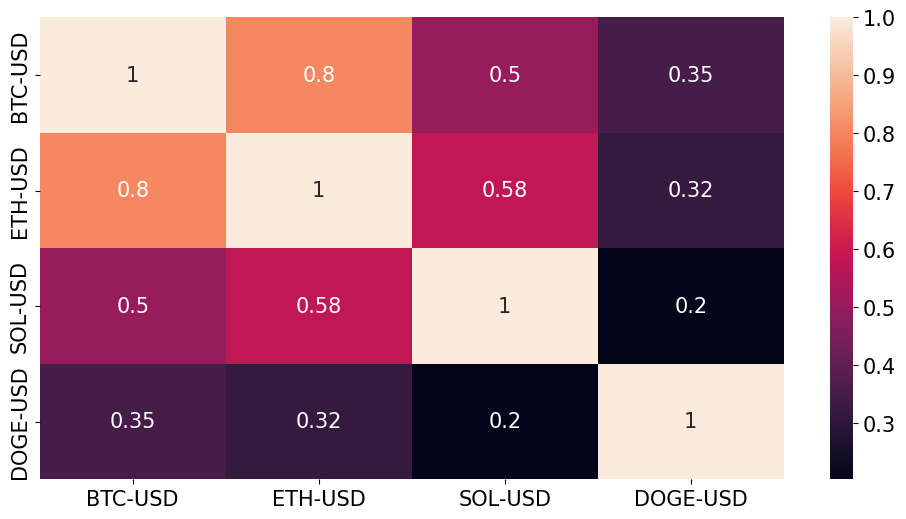

In [56]:
sns.heatmap(crypto.pct_change().corr(),annot=True);

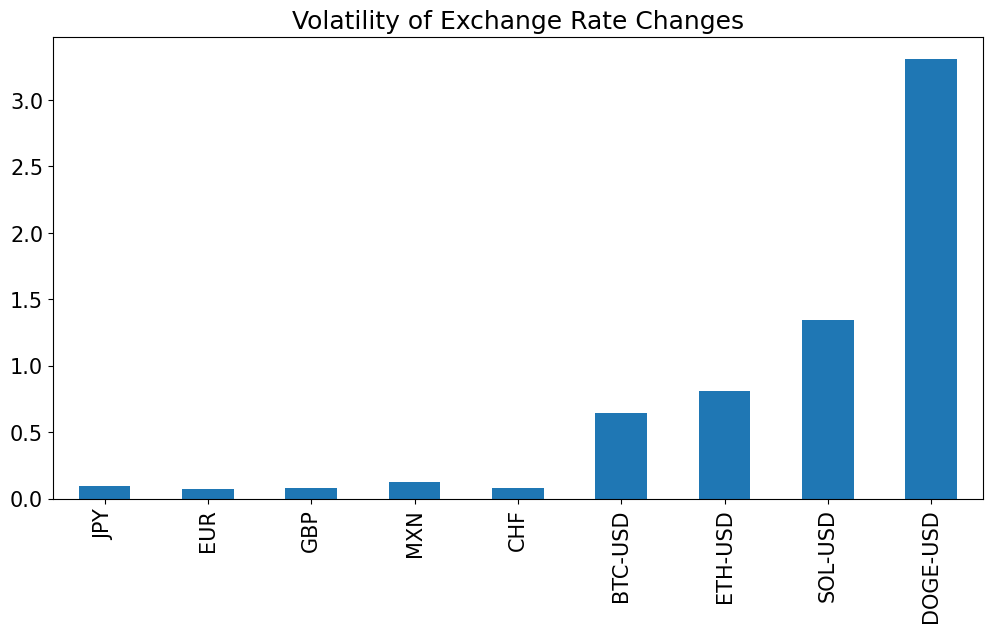

In [57]:
ANNUALIZE= np.sqrt(52)
(rets_fx_wkly.std()*ANNUALIZE).plot.bar(title='Volatility of Exchange Rate Changes');